In [133]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, recall_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
import datetime
import os
import csv
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats
import decimal
import researchpy as rp

np.set_printoptions(linewidth=np.inf)

import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [134]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
logsFolder = "4-logs"

inputPretestFolder = inputFolder + r"\1-pretest"
inputPosttestFolder = inputFolder + r"\2-posttest"

dataVisualizationTopLimit = 20

testSize = 0.25
genericRandomState = 0
splitRandomState = 0
samplingStrategy = 0.2
percentileNumberStd = 90
percentileNumberCorrelation = 90

splitsNumber = 12

In [135]:
# Funciones utilitarias de archivos
def readCsvAsDict(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  data = df.to_dict('records')
  return data

def readCsvAsDf(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  return df

def writeDictToCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeDfToCsv(data, pathCsv, encoding='utf-8', header=True):
  data.to_csv(path_or_buf = pathCsv, encoding = encoding, header=header, index=False)

def parseTranspose(df):
  transposedDf = df.transpose()
  transposedDf = transposedDf.reset_index()
  transposedDf.columns = transposedDf.iloc[0]
  transposedDf = transposedDf[1:]

  return transposedDf

In [136]:
def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return a + " * 10^" + str(b)

In [137]:
def showDescriptiveTables(preTestDf, postTestDf, indicator):
  indicatorPreTestData, indicatorPostTestData = preTestDf[indicator].to_numpy(), postTestDf[indicator].to_numpy()
  
  descriptiveMeasuresDf = pd.DataFrame({
    "Nombre": ["{}_PreTest".format(indicator.capitalize()), "{}_PostTest".format(indicator.capitalize())],
    "Muestra": [ "{:.0f}".format(indicatorPreTestData.size), "{:.0f}".format(indicatorPostTestData.size) ],
    "Mínimo": [ "{:.4f}".format(indicatorPreTestData.min()), "{:.4f}".format(indicatorPostTestData.min()) ],
    "Máximo": [ "{:.4f}".format(indicatorPreTestData.max()), "{:.4f}".format(indicatorPostTestData.max()) ],
    "Media": [ "{:.4f}".format(indicatorPreTestData.mean()), "{:.4f}".format(indicatorPostTestData.mean()) ],
    "Desviación estándar": [ "{:.4f}".format(indicatorPreTestData.std()), "{:.4f}".format(indicatorPostTestData.std()) ],
  })

  display(descriptiveMeasuresDf.style.hide_index())

In [138]:
def showMeanDifference(preTestDf, postTestDf, indicator):
  indicatorPreTestData, indicatorPostTestData = preTestDf[indicator].to_numpy(), postTestDf[indicator].to_numpy()

  colors = ["#7CAFDE", "#7CAFDE"]
  classes = [ "PreTest", "PostTest"]
  values =  [ indicatorPreTestData.mean(), indicatorPostTestData.mean() ]
  graph = plt.bar(classes, values, color=colors)

  percentage = []
  for value in values:
    percentage.append(value)

  if indicator != "tiempo":
    for index, p in enumerate(graph):
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2, y+0.5*height, "{:.2%}".format(percentage[index]), ha='center', weight='bold')

    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.ylabel("Porcentaje")
  else:
    for index, p in enumerate(graph):
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2, y+0.5*height, "{:.2f}s".format(percentage[index]), ha='center', weight='bold')

    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, y: "{:.0f}s".format(x)))
    plt.ylabel("Segundos")
  
  plt.title("Media de {} (PreTest y PostTest)".format(indicator))
  plt.show()

In [139]:
def showNormalityTable(preTestDf, postTestDf, indicator):
  indicatorPreTestData, indicatorPostTestData = preTestDf[indicator].to_numpy(), postTestDf[indicator].to_numpy()

  preTestStatistic, preTestPValue = stats.shapiro(indicatorPreTestData)
  postTestStatistic, postTestPValue = stats.shapiro(indicatorPostTestData)
  
  descriptiveMeasuresDf = pd.DataFrame({
    "Nombre": ["PreTest_{}".format(indicator.capitalize()), "PostTest_{}".format(indicator.capitalize())],
    "Grados de libertad": [ "{:.0f}".format(indicatorPreTestData.size), "{:.0f}".format(indicatorPostTestData.size) ],
    "Estadístico de prueba": [ "{:.4f}".format(preTestStatistic), "{:.4f}".format(postTestStatistic) ],
    "Valor P": [
      "\\num{{{:.2e}}}".format(preTestPValue) if preTestPValue < 0.0001 else "{:.4f}".format(preTestPValue),
      "\\num{{{:.2e}}}".format(postTestPValue) if postTestPValue < 0.0001 else "{:.4f}".format(postTestPValue),
    ],
  })

  display(descriptiveMeasuresDf.style.hide_index())

In [140]:
def showNormalityHistogram(df, testType, indicator):
  data = df[indicator].to_numpy()
  
  mu, std = stats.norm.fit(data) 

  plt.hist(data, bins=9, color="tab:blue", ec="black")

  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = stats.norm.pdf(x, mu, std)*(xmax - xmin)*5

  plt.plot(x, p, 'k')
  plt.title("{} {} ({})".format("Prueba de normalidad de", indicator, testType))

  plt.show()

def showNormalityHistogramDifference(preTestDf, postTestDf, indicator):
  showNormalityHistogram(preTestDf, "PreTest", indicator)
  showNormalityHistogram(postTestDf, "PostTest", indicator)


In [141]:
def showWilcoxonTable(preTestDf, postTestDf, indicator):
  indicatorPreTestData, indicatorPostTestData = preTestDf[indicator].to_numpy(), postTestDf[indicator].to_numpy()

  desc, varAdj, res = rp.signrank(group1=indicatorPreTestData, group2=indicatorPostTestData, zero_method="wilcox").conduct()

  zStatistic, wStatistic, pValue = res.loc[0].iat[0], res.loc[0].iat[1], res.loc[0].iat[2]

  descriptiveMeasuresDf = pd.DataFrame({
    "Nombre": ["{}_PreTest_PostTest".format(indicator.capitalize())],
    "Grados de libertad": [ "{:.0f}".format(indicatorPreTestData.size)],
    "Estadístico de prueba": [ "{:.2f}".format(zStatistic)],
    "Valor P": [ "\\num{{{:.2e}}}".format(pValue) if pValue < 0.0001 else "{:.4f}".format(pValue) ],
  })

  display(descriptiveMeasuresDf.style.hide_index())

In [142]:
def showWilcoxonGraph(preTestDf, postTestDf, indicator):
  indicatorPreTestData, indicatorPostTestData = preTestDf[indicator].to_numpy(), postTestDf[indicator].to_numpy()

  desc, varAdj, res = rp.signrank(group1=indicatorPreTestData, group2=indicatorPostTestData, zero_method="wilcox").conduct()

  zStatistic, wStatistic, pValue = res.loc[0].iat[0], res.loc[0].iat[1], res.loc[0].iat[2]

  x = np.arange(-3,3,0.001)
  
  # Obteniendo valores de alpha
  alpha = 0.05
  zAlpha = stats.norm.ppf(alpha)

  # Graficando la función
  y = stats.norm.pdf(x, 0, 1)

  # Graficando áreas hasta zAlpha
  z = x[x<zAlpha]
  plt.plot(x, y)
  plt.fill_between(z, 0, stats.norm.pdf(z, 0, 1), color="tab:red")
  plt.xticks([zAlpha],['$Z_{α} = ' + '{:.2f}$'.format(zAlpha)])
  plt.text(-2.4, 0.08, '$Z_{c} = ' + '{:.2f}$'.format(zStatistic), horizontalalignment='center')
  plt.text(0, 0.16, 'Región de\nAceptación', fontsize=13, horizontalalignment='center')
  plt.text(-2.4, 0.16, 'Región de\nRechazo', fontsize=13, horizontalalignment='center', color="tab:red")

  plt.title("{} {}".format("Prueba de Wilcoxon de", indicator))
  plt.show()

In [143]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))

  # Obteniendo data de pretest y postest
  preTestDf = readCsvAsDf(os.path.join(inputPretestFolder, 'result.csv'))
  postTestDf = readCsvAsDf(os.path.join(inputPosttestFolder, 'result.csv'))

  # Definiendo los indicadores
  indicators = ["exactitud", "precision", "sensibilidad", "robustez", "tiempo"]
  #indicators = ["exactitud"]

  # Iterando por cada indicador
  for indicator in indicators:
    #showDescriptiveTables(preTestDf, postTestDf, indicator)
    #showMeanDifference(preTestDf, postTestDf, indicator)
    #showNormalityTable(preTestDf, postTestDf, indicator)
    #showNormalityHistogramDifference(preTestDf, postTestDf, indicator)
    showWilcoxonTable(preTestDf, postTestDf, indicator)
    showWilcoxonGraph(preTestDf, postTestDf, indicator)
    pass

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-07-10 03:09:33.236429


Nombre,Grados de libertad,Estadístico de prueba,Valor P
Exactitud_PreTest_PostTest,48,-5.88,\num{4.01e-09}


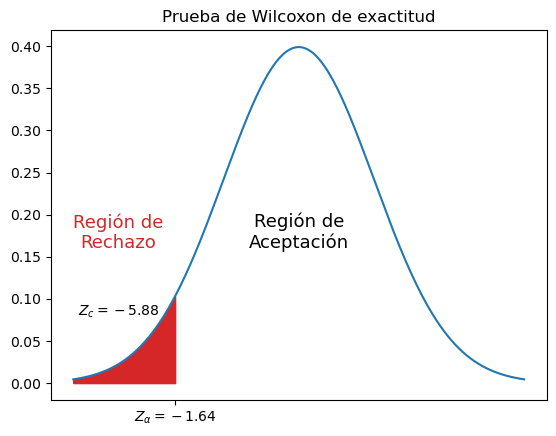

Nombre,Grados de libertad,Estadístico de prueba,Valor P
Precision_PreTest_PostTest,48,-5.44,\num{5.26e-08}


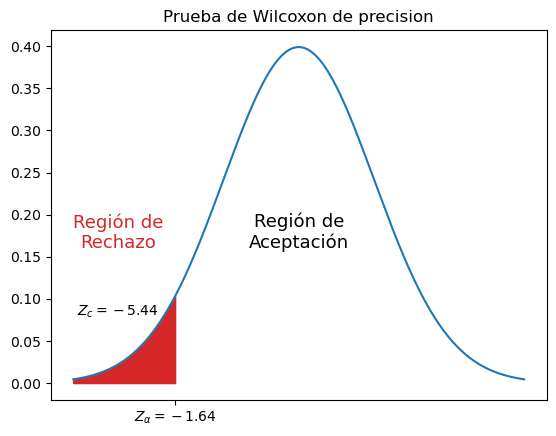

Nombre,Grados de libertad,Estadístico de prueba,Valor P
Sensibilidad_PreTest_PostTest,48,-5.52,\num{1.98e-10}


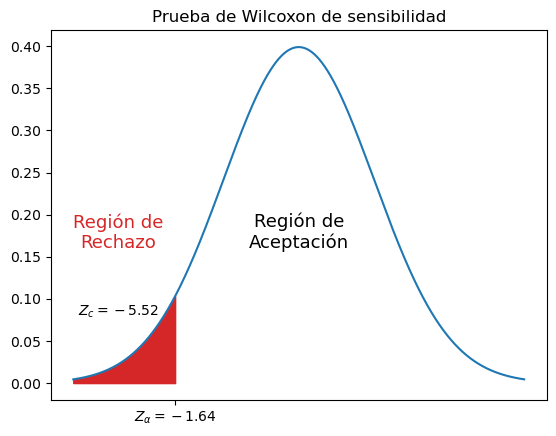

Nombre,Grados de libertad,Estadístico de prueba,Valor P
Robustez_PreTest_PostTest,48,-5.91,\num{4.97e-13}


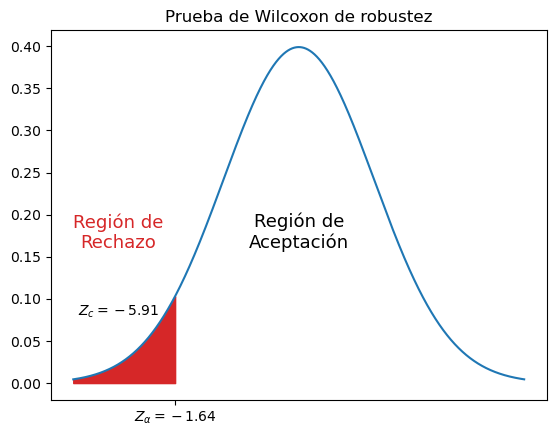

Nombre,Grados de libertad,Estadístico de prueba,Valor P
Tiempo_PreTest_PostTest,48,3.19,0.0011


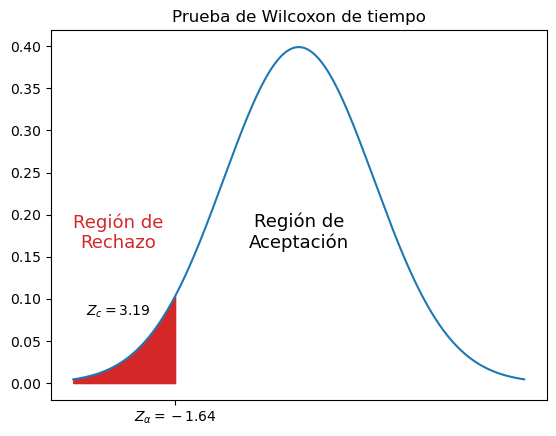

Fin: 2023-07-10 03:09:33.777717
Tiempo: 0:00:00.541288


In [144]:
if __name__ == "__main__":
  main()